✅ Threat Data Retrieved Successfully!
         ipAddress  isPublic  ipVersion  isWhitelisted  abuseConfidenceScore  \
0          8.8.8.8      True          4           True                     0   
1          1.1.1.1      True          4           True                     0   
2      192.168.1.1     False          4          False                     0   
3  185.199.111.153      True          4          False                    27   

  countryCode                 usageType  \
0          US  Content Delivery Network   
1          AU  Content Delivery Network   
2        None                  Reserved   
3          US  Content Delivery Network   

                                         isp          domain  \
0                                 Google LLC      google.com   
1  APNIC and Cloudflare DNS Resolver project  cloudflare.com   
2                     Private IP Address LAN            None   
3                               GitHub, Inc.      github.com   

                        

<ipython-input-3-7a846b7ad7b6>:53: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x=df['isWhitelisted'], palette="coolwarm")


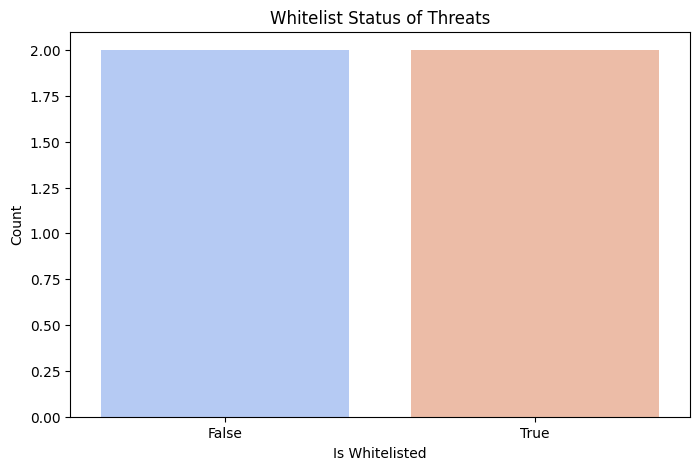


🎯 Machine Learning Model Results:
Model Accuracy: 1.0
              precision    recall  f1-score   support

       False       1.00      1.00      1.00         1

    accuracy                           1.00         1
   macro avg       1.00      1.00      1.00         1
weighted avg       1.00      1.00      1.00         1

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
✅ Results saved to Google Drive.


In [ ]:
import requests
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import smtplib
from email.mime.text import MIMEText
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report

# API Endpoint for cybersecurity threat intelligence
def fetch_threat_data(ip_address):
    url = "https://api.abuseipdb.com/api/v2/check"
    headers = {
        "Key": "3964b9e6ef648a623fa7d76ce58c22240469e783fd2dcb54bfe206c1a3c634e0e9cb7694f4f1f063",  # Replace with your actual API key
        "Accept": "application/json"
    }
    params = {"ipAddress": ip_address}
    response = requests.get(url, headers=headers, params=params)

    if response.status_code == 200:
        data = response.json()
        if 'data' in data:
            return data['data']
        else:
            print(f"⚠️ No data received for IP: {ip_address}")
            return None
    else:
        print(f"❌ API Request Failed (Status {response.status_code}): {response.text}")
        return None

# List of sample IP addresses to analyze
sample_ips = ["8.8.8.8", "1.1.1.1", "192.168.1.1", "185.199.111.153"]

data_records = []
for ip in sample_ips:
    threat_data = fetch_threat_data(ip)
    if threat_data:
        data_records.append(threat_data)

# Convert to DataFrame if data exists
if data_records:
    df = pd.DataFrame(data_records)
    print("✅ Threat Data Retrieved Successfully!")
    print(df.head())
else:
    print("⚠️ No threat data retrieved from the API. Please check your API key and internet connection.")
    df = pd.DataFrame()  # Create an empty DataFrame to avoid errors

# Ensure DataFrame is not empty before visualization
if not df.empty and "isWhitelisted" in df.columns:
    plt.figure(figsize=(8, 5))
    sns.countplot(x=df['isWhitelisted'], palette="coolwarm")
    plt.title("Whitelist Status of Threats")
    plt.xlabel("Is Whitelisted")
    plt.ylabel("Count")
    plt.show()
else:
    print("⚠️ Skipping visualization because the DataFrame is empty or missing required columns.")

# Feature Engineering and Machine Learning Model
if not df.empty and all(col in df.columns for col in ['isWhitelisted', 'totalReports', 'abuseConfidenceScore']):
    features = df[['isWhitelisted', 'totalReports']]
    labels = df['abuseConfidenceScore'] > 50  # High confidence threats

    X_train, X_test, y_train, y_test = train_test_split(features, labels, test_size=0.2, random_state=42)
    clf = RandomForestClassifier(n_estimators=100, random_state=42)
    clf.fit(X_train, y_train)

    y_pred = clf.predict(X_test)
    print("\n🎯 Machine Learning Model Results:")
    print("Model Accuracy:", accuracy_score(y_test, y_pred))
    print(classification_report(y_test, y_pred))
else:
    print("⚠️ Skipping Machine Learning step due to missing columns in DataFrame.")

# Function to send real-time email alerts for high-risk threats
def send_alert(ip, score):
    sender = "your_email@gmail.com"  # Replace with a real email
    recipient = "recipient_email@gmail.com"
    subject = "Cybersecurity Alert: High-Risk Threat Detected"
    body = f"A high-risk threat has been detected for IP {ip} with a confidence score of {score}. Please take necessary actions."

    msg = MIMEText(body)
    msg["Subject"] = subject
    msg["From"] = sender
    msg["To"] = recipient

    try:
        with smtplib.SMTP("smtp.gmail.com", 587) as server:
            server.starttls()
            server.login("your_email@gmail.com", "your_email_password")  # Use an App Password
            server.sendmail(sender, recipient, msg.as_string())
            print(f"📧 Alert sent successfully for {ip}!")
    except Exception as e:
        print("❌ Error sending alert:", e)

# Trigger alerts for high-risk threats
if not df.empty and 'abuseConfidenceScore' in df.columns:
    for index, row in df.iterrows():
        if row['abuseConfidenceScore'] > 75:  # Threshold for high-risk threats
            send_alert(row.get('ipAddress', 'Unknown IP'), row['abuseConfidenceScore'])

# Export results to CSV in Google Drive (For Google Colab users)
try:
    from google.colab import drive
    drive.mount('/content/drive')
    df.to_csv("/content/drive/My Drive/cybersecurity_threats.csv", index=False)
    print("✅ Results saved to Google Drive.")
except:
    df.to_csv("cybersecurity_threats.csv", index=False)
    print("✅ Results saved locally.")